In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import os
import joblib

In [6]:
plt.rcParams["axes.unicode_minus"] = False

if platform.system() == "Darwin":  # macOS
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":  # Windows
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)
elif platform.system() == "Linux":  # Linux (Ubuntu, Docker 등)
    font_path = "fonts/NanumGothic.ttf"
    if not os.path.exists(font_path):
        st.error("NanumGothic.ttf 폰트 파일이 존재하지 않습니다. 'fonts' 폴더 내에 폰트 파일을 확인하세요.")
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc("font", family=font_name)

In [9]:
df_kia_regional = pd.read_csv("../../data/processed/기아_지역별수출실적_전처리.csv")
df_kia_regional

,차량 구분,국가명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,연도
0,승용차,US,1048.0,633.0,627.0,245.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,5.0,2023
1,휴양용 차량,US,33056.0,29697.0,31985.0,29103.0,28763.0,26013.0,27234.0,22619.0,20969.0,24759.0,33951.0,30920.0,2023
2,상업용 차량,US,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2023
3,특수 차량,US,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,2023
4,CKD(모듈형 조립 방식),US,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,휴양용 차량,China,0.0,0,0,0,0,0,0,0,0,0,0,0,2025
186,상업용 차량,China,0.0,0,0,0,0,0,0,0,0,0,0,0,2025
187,특수 차량,China,0.0,0,0,0,0,0,0,0,0,0,0,0,2025
188,CKD(특수 차량 제외),China,0.0,0,0,0,0,0,0,0,0,0,0,0,2025


In [11]:
mod_df = df_kia_regional.groupby(["국가명", "차량 구분"])[["1월","2월","3월","4월","5월","6월","7월","8월","9월","10월","11월","12월"]].sum()
mod_df

1월              2월  \
국가명            차량 구분                                                  
Asia / Pacific CKD(모듈형 조립 방식)                3384.0          4184.0   
               CKD(특수 차량 제외)            2,2603040.0          3,2000   
               CKD(특수 차량)                    4860.0             240   
               상업용 차량                 359.0379225.0       448.03660   
               승용차                 2206.02,231409.0    1781.01,9980   
...                                             ...             ...   
US             상업용 차량                         0.0-0           0.0-0   
               승용차                    1048.0-4518.0         633.0-0   
               총합                      34104.034743    30330.028607   
               특수 차량                          0.000           0.0-0   
               휴양용 차량          33056.034,74323997.0  29697.028,6070   

                                           3월              4월              5월  \
국가명            차량 구분                                                            
Asia / Pacific CKD(모듈형 조립 방식)          3464.0          2536.0          2072.0   
               CKD(특수 차량 제외)           3,0000          3,0400          3,3400   
               CKD(특수 차량)                 720             480             240   
               상업용 차량               298.03810       328.02600       301.01910   
               승용차               2515.02,2370    1869.03,2490    2042.02,8870   
...                                       ...             ...             ...   
US             상업용 차량                   0.0-0           0.000           0.0-0   
               승용차                627.03,3420     245.06,3590       0.08,1360   
               총합               32612.034,209   29348.042,268   28763.037,104   
               특수 차량                    0.0-0           0.000           0.0-0   
               휴양용 차량          31985.030,8670  29103.035,9090  28763.028,9680   

                                           6월              7월              8월  \
국가명            차량 구분                                                            
Asia / Pacific CKD(모듈형 조립 방식)          2456.0          1920.0          2760.0   
               CKD(특수 차량 제외)           2,9400          3,2200          3,0600   
               CKD(특수 차량)                 360             600             720   
               상업용 차량               353.02470       319.02530       342.03280   
               승용차               2144.02,4590    1290.01,9510    1424.02,0290   
...                                       ...             ...             ...   
US             상업용 차량                   0.0-0             000           0.0-0   
               승용차                  0.07,8180       2.08,2030       0.07,4200   
               총합               26013.035,703   27236.035,129   22619.032,519   
               특수 차량                      0-0             000             0-0   
               휴양용 차량          26013.027,8850  27234.026,9260  22619.025,0990   

                                           9월             10월             11월  \
국가명            차량 구분                                                            
Asia / Pacific CKD(모듈형 조립 방식)          2884.0          3324.0          2348.0   
               CKD(특수 차량 제외)           3,8200          5,0400          4,6400   
               CKD(특수 차량)                 480             480             500   
               상업용 차량               104.02490        73.01460        87.01440   
               승용차                 1607.04850      1504.09440    1627.01,0250   
...                                       ...             ...             ...   
US             상업용 차량                   0.0-0           0.0-0           0.0-0   
               승용차                  0.06,9460       4.05,1540       0.01,1400   
               총합               20969.028,047   24763.030,140   33951.015,057   
               특수 차량                    0.0-0           0.0-0           0.0-0   
               휴양용 차량          20969.021,1010

In [14]:
mod_df.loc[mod_df.index == ('Asia / Pacific', 'CKD(특수 차량)'), :]

,,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
국가명,차량 구분,,,,,,,,,,,,
Asia / Pacific,CKD(특수 차량),4860.0,240,720,480,240,360,600,720,480,480,500,360


/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


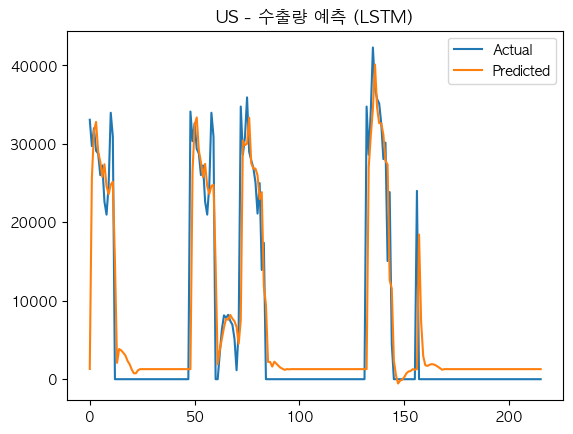

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


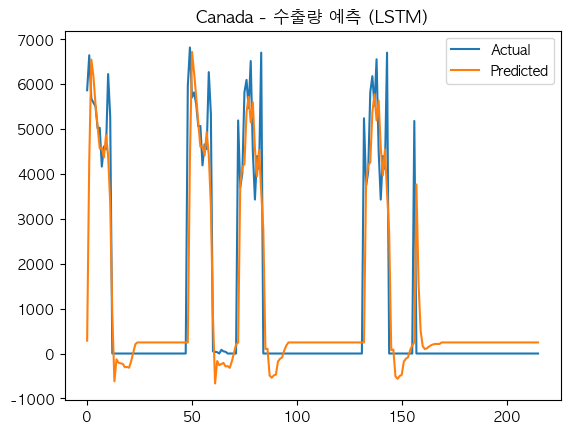

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


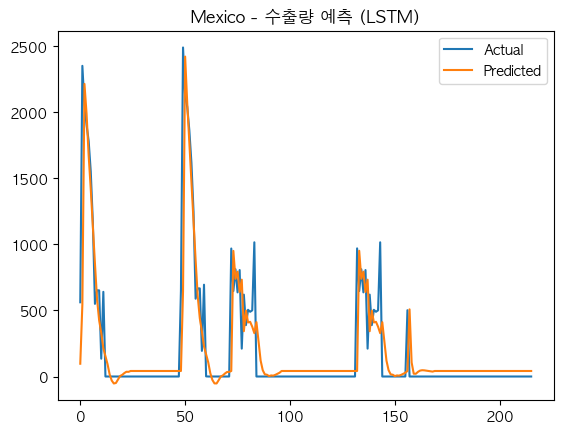

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


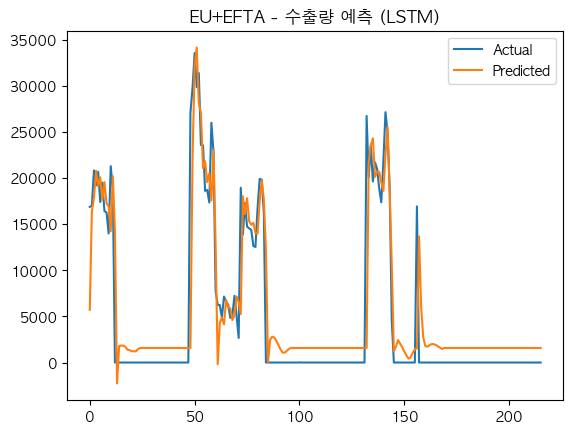

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


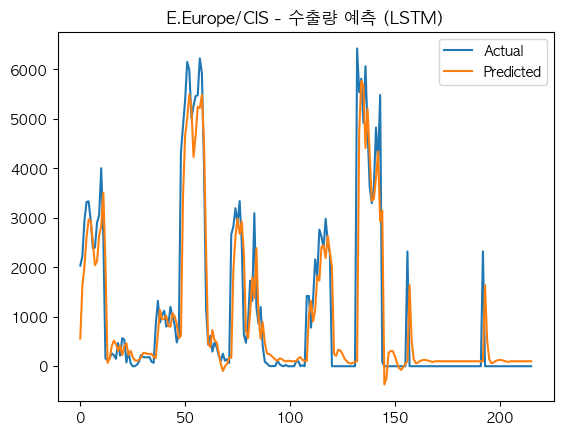

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


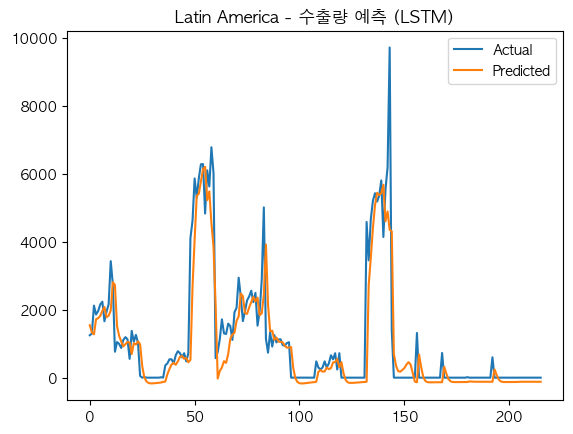

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


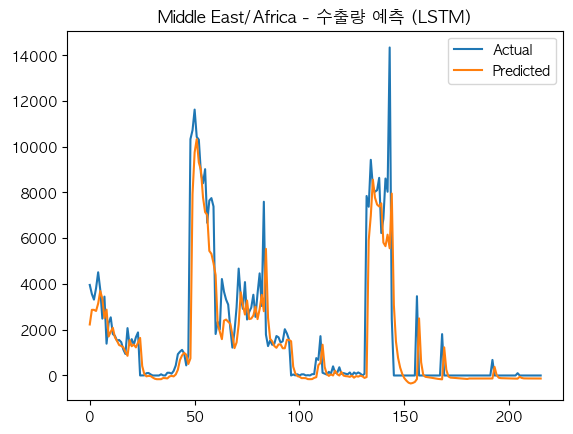

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


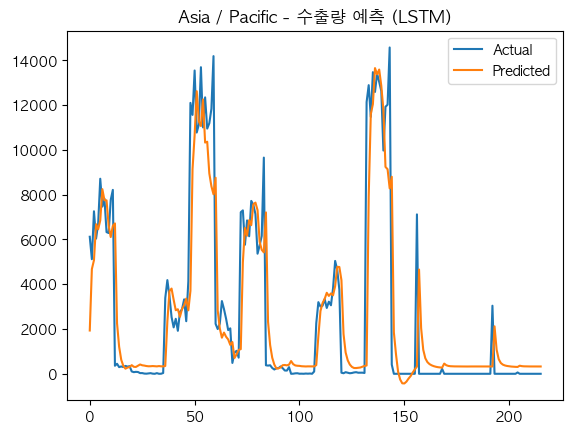

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


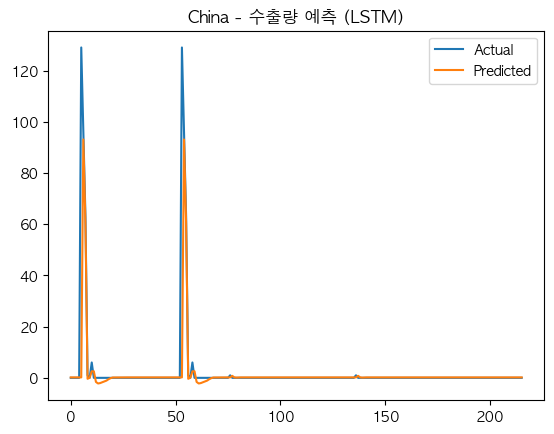

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


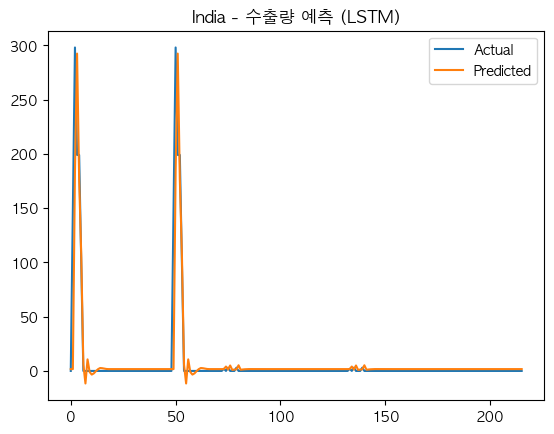

In [7]:
# 데이터 로딩
df = pd.read_csv('../../data/processed/기아_지역별수출실적_전처리.CSV')

# 전처리: 총합만 필터링
# df = df[df['차량 구분'] == '총합']

df.replace("-", 0, inplace=True)

# 쉼표 제거 및 숫자형 변환
month_cols = ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월']
df[month_cols] = df[month_cols].apply(lambda x: x.astype(str).str.replace(',', '').astype(float))

# 국가별 시계열 데이터 생성
def create_dataset(series, time_steps=12):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled) - time_steps):
        X.append(scaled[i:i+time_steps])
        y.append(scaled[i+time_steps])
    return np.array(X), np.array(y), scaler

# 학습 + 예측
country_models = {}
for country in df['국가명'].unique():
    ts = df[df['국가명'] == country][month_cols].values.flatten()
    X, y, scaler = create_dataset(ts)

    model = Sequential()
    model.add(LSTM(32, input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X, y, epochs=50, batch_size=4, verbose=0)

    y_pred = model.predict(X)
    y_pred_inverse = scaler.inverse_transform(y_pred)

    # 결과 시각화
    plt.figure()
    plt.plot(ts[12:], label='Actual')
    plt.plot(y_pred_inverse, label='Predicted')
    plt.title(f'{country} - 수출량 예측 (LSTM)')
    plt.legend()
    plt.show()

    country_models[country] = model

model.